# More about Henbun

In this notebook, we describe more details about Henbun through Variational method.

# Libraries to be used.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import Henbun as hb

# Toy data

In [2]:
X = np.linspace(0,6,40).reshape(-1,1)
Y = 0.5*X + np.random.randn(40,1)*0.3 + 0.4

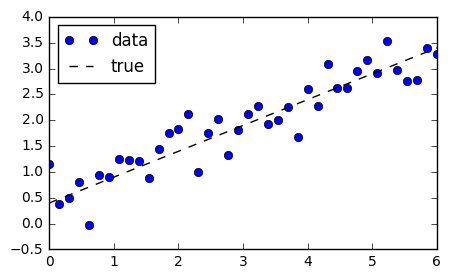

In [3]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, 0.5*X+0.4, '--k', label='true')
plt.legend(loc='best')

# Variational linear model.

Here, we construct a linear model within Bayesian framework.

The likelihood is assumed as Gaussian,
$$
p(y_i | a, b, x_i) = \mathcal{N}(y_i | a + b*x_i, c)
$$
where $\sigma$ is the variance parameter.

We assume weak prior for $a$, $b$ and $\sigma$,
$$
p(a) = \mathcal{N}(a|0,1) \\
p(b) = \mathcal{N}(b|0,1) \\
p(c) = \mathcal{N}(c|0,1) \\
$$

In this model, we approximate the posterior distribution by independent Gaussian, i.e.
$$
p(a|\mathbf{x},\mathbf{y}) \sim q(a) = \mathcal{N}(a| \mu_a, \sigma_a) \\
p(b|\mathbf{x},\mathbf{y}) \sim q(b) = \mathcal{N}(b| \mu_b, \sigma_b) \\
p(c|\mathbf{x},\mathbf{y}) \sim q(c) = \mathcal{N}(c| \mu_c, \sigma_c) \\
$$
where $\mu_a, \mu_b, \mu_c$ and $\sigma_a, \sigma_b, \sigma_c$ are the variational parameters to be optimized.

By this approximation, the free energy (evidence lower bound: ELBO) to be maximized is
$$
\mathrm{ELBO}(a, b, c) = 
\int q(a)q(b)q(c) \log p(\mathbf{y}|\mathbf{x}, a, b, c)\; \mathrm{d}a\;\mathrm{d}b\;\mathrm{d}c \\
- \mathrm{KL}[q(a)||p(a)]  \\
- \mathrm{KL}[q(b)||p(b)]  \\
- \mathrm{KL}[q(c)||p(c)]
$$

## Construct the variational model

In [4]:
# Construct a variational linear model
class VariationalLinearModel(hb.model.Model):
    def setUp(self):
        # data should be stored in hb.param.Data class
        self.X = hb.param.Data(X)
        self.Y = hb.param.Data(Y)
        
        # Variational parameters 
        self.a = hb.variationals.Normal(shape=[1])
        self.b = hb.variationals.Normal(shape=[1])
        self.c = hb.variationals.Normal(shape=[1])
        
        # To access the posterior samples, 
        # we define op that returns samples of the fit.
        # As described in Henbun_structure.ipynb, tf_mode is used here.
        with self.tf_mode():
            self.fit = self.a + self.b*self.X
        
    @hb.model.AutoOptimize()
    def elbo(self):
        """
        This method returns the sum of log-likelihood and log-prior.
        """
        # log likelihood
        log_lik = hb.densities.gaussian(self.Y, self.fit, tf.exp(self.c))
        # KL() methods automatically gather KL for all the variational parameters.
        KL = self.KL()
        return tf.reduce_sum(log_lik) - KL

In [5]:
vlinear_model = VariationalLinearModel()

## What values are inside `hb.variationals.Normal`

hb.variationals.Normal is a variational parameter with a Normal prior.  
This class has two hb.param.Variables, `q_mu` and `q_sqrt`.

In [6]:
vlinear_model.initialize()
print(vlinear_model.a.q_mu.value, vlinear_model.a.q_sqrt.value)

[-0.05556884] [ 0.02245434]


`q_mu` corresponds to $\mu_a$ and `q_sqrt` corresponds to $\sqrt{\log \sigma_a}$.

Henbun will seek the best variational parameters (`q_mu` and `q_sqrt`) that maximizes ELBO.

## Compilation and optimization

In [7]:
vlinear_model.elbo().compile()
vlinear_model.elbo().optimize(maxiter=50000)

compiling...


## Result

In [8]:
# a
print(vlinear_model.a.q_mu.value, vlinear_model.a.q_sqrt.value)
# b
print(vlinear_model.b.q_mu.value, vlinear_model.b.q_sqrt.value)
# c
print(vlinear_model.c.q_mu.value, vlinear_model.c.q_sqrt.value)

[ 0.52371728] [-2.83439779]
[ 0.46568948] [-4.08174992]
[-1.98415232] [-1.50527358]


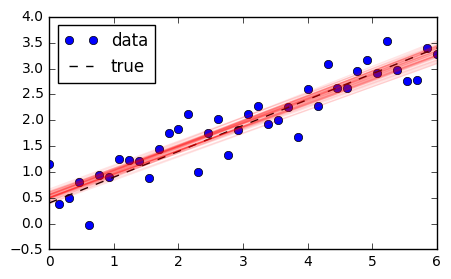

In [9]:
# plot the samples from the posterior
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, 0.5*X+0.4, '--k', label='true')
for _ in range(50):
    plt.plot(X, vlinear_model.run(vlinear_model.fit), '-r', alpha=0.1)
plt.plot()
plt.legend(loc='best')

## Note

Note that we approximate the independent posterior for a, b, c, although the true posterior should have correlation.

Henbun also provides 'fullrank' variational approximation.  
See docstring for `hb.variationals.Variational`.

# How does variational model work.

## Variational expectation
The main difficulty for calculating ELBO is the variational-expectation term
$$
\int q(a)q(b)q(c) \log p(\mathbf{y}|\mathbf{x}, a, b, c)\; \mathrm{d}a\;\mathrm{d}b\;\mathrm{d}c
$$
where in a, b, c are usually multidimensional (in our case, it is 3-dimensional integration).

We approximate this integral by Monte-Carlo method,
$$
\mathrm{ELBO} \sim \log p(\mathbf{y}|\mathbf{x}, a^\mathrm{s}, b^\mathrm{s}, c^\mathrm{s})
$$
where $a^\mathrm{s}, b^\mathrm{s}, c^\mathrm{s}$ are the samples from $q(a), q(b), q(c)$ respectively.

Since this equation gives unbiased approximation of the True ELBO,  
we can optimize this by stochastic optimization.

## kullback leibler divergence
The KL term is also approximated by Monte-Carlo method,
$$
\mathrm{KL}[q(a)||p(a)]
= \int q(a) \log\frac{q(a)}{p(a)} \mathrm{d}a
\sim a^\mathrm{s} \log\frac{q(a^\mathrm{s})}{p(a^\mathrm{s})}
$$